<a href="https://colab.research.google.com/github/anggitwr/LeavesImage-Classification/blob/main/16_label_Klasifikasi_tanaman_ep30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
from matplotlib import image, pyplot
import pandas as pd
from google.colab import drive

In [ ]:
# Unzip Compress File
zip_file_path = "./drive/MyDrive/klasifikasi/DATASET TANAMAN HERBAL3.zip"  # Replace with the actual path to your ZIP file
destination_dir = "./data/"  # Replace with the desired path to create the directory

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Extract the contents of the ZIP file to the destination directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

In [ ]:
# Declaration file location
sdir = './data/DATASET TANAMAN HERBAL3/Data Training/'
labels = os.listdir(sdir)

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  ./data/DATASET TANAMAN HERBAL3/Data Training/D...  Daun Kunyit
1  ./data/DATASET TANAMAN HERBAL3/Data Training/D...  Daun Kunyit
2  ./data/DATASET TANAMAN HERBAL3/Data Training/D...  Daun Kunyit
3  ./data/DATASET TANAMAN HERBAL3/Data Training/D...  Daun Kunyit
4  ./data/DATASET TANAMAN HERBAL3/Data Training/D...  Daun Kunyit
Daun Kemangi       169
Teh Hijau          168
Lidah Buaya        155
Daun Sirih         150
Kaca               146
Plastik            144
Kain               142
Daun Mint          140
Daun Jambu Biji    140
Daun Pepaya        140
Daun Sirsak        140
Daun Kari          136
Kertas             136
Daun Kunyit        135
Besi               131
Kardus             112
Name: labels, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
# from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
# from sklearn.metrics import confusion_matrix, classification_report
# from IPython.display import display, HTML
from keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import RMSprop

In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1827   test_df length:  228   valid_df length:  229


In [ ]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(rescale=1./255,
                       horizontal_flip=True,
                       vertical_flip=True,
                       rotation_range=15,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       fill_mode='reflect',
                       brightness_range=(0.8,1.2),
                      )
train_gen=gen.flow_from_dataframe( train_df,
                                  x_col='filepaths',
                                  y_col='labels',
                                  target_size=img_size,
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=True,
                                  batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255,
                            horizontal_flip=True,
                            vertical_flip=True,
                           )
valid_gen=validgen.flow_from_dataframe( valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255,
                          shear_range=0.2,
                          zoom_range=0.1,
                          horizontal_flip=True,
                          )
test_gen=testgen.flow_from_dataframe( test_df,
                                     x_col='filepaths',
                                     y_col='labels',
                                     target_size=img_size,
                                     class_mode='categorical',
                                     color_mode='rgb',
                                     shuffle=False,
                                     batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  76   test steps:  3
Found 1827 validated image filenames belonging to 16 classes.
Found 229 validated image filenames belonging to 16 classes.
Found 228 validated image filenames belonging to 16 classes.
['Besi', 'Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Kaca', 'Kain', 'Kardus', 'Kertas', 'Lidah Buaya', 'Plastik', 'Teh Hijau']


In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<20:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

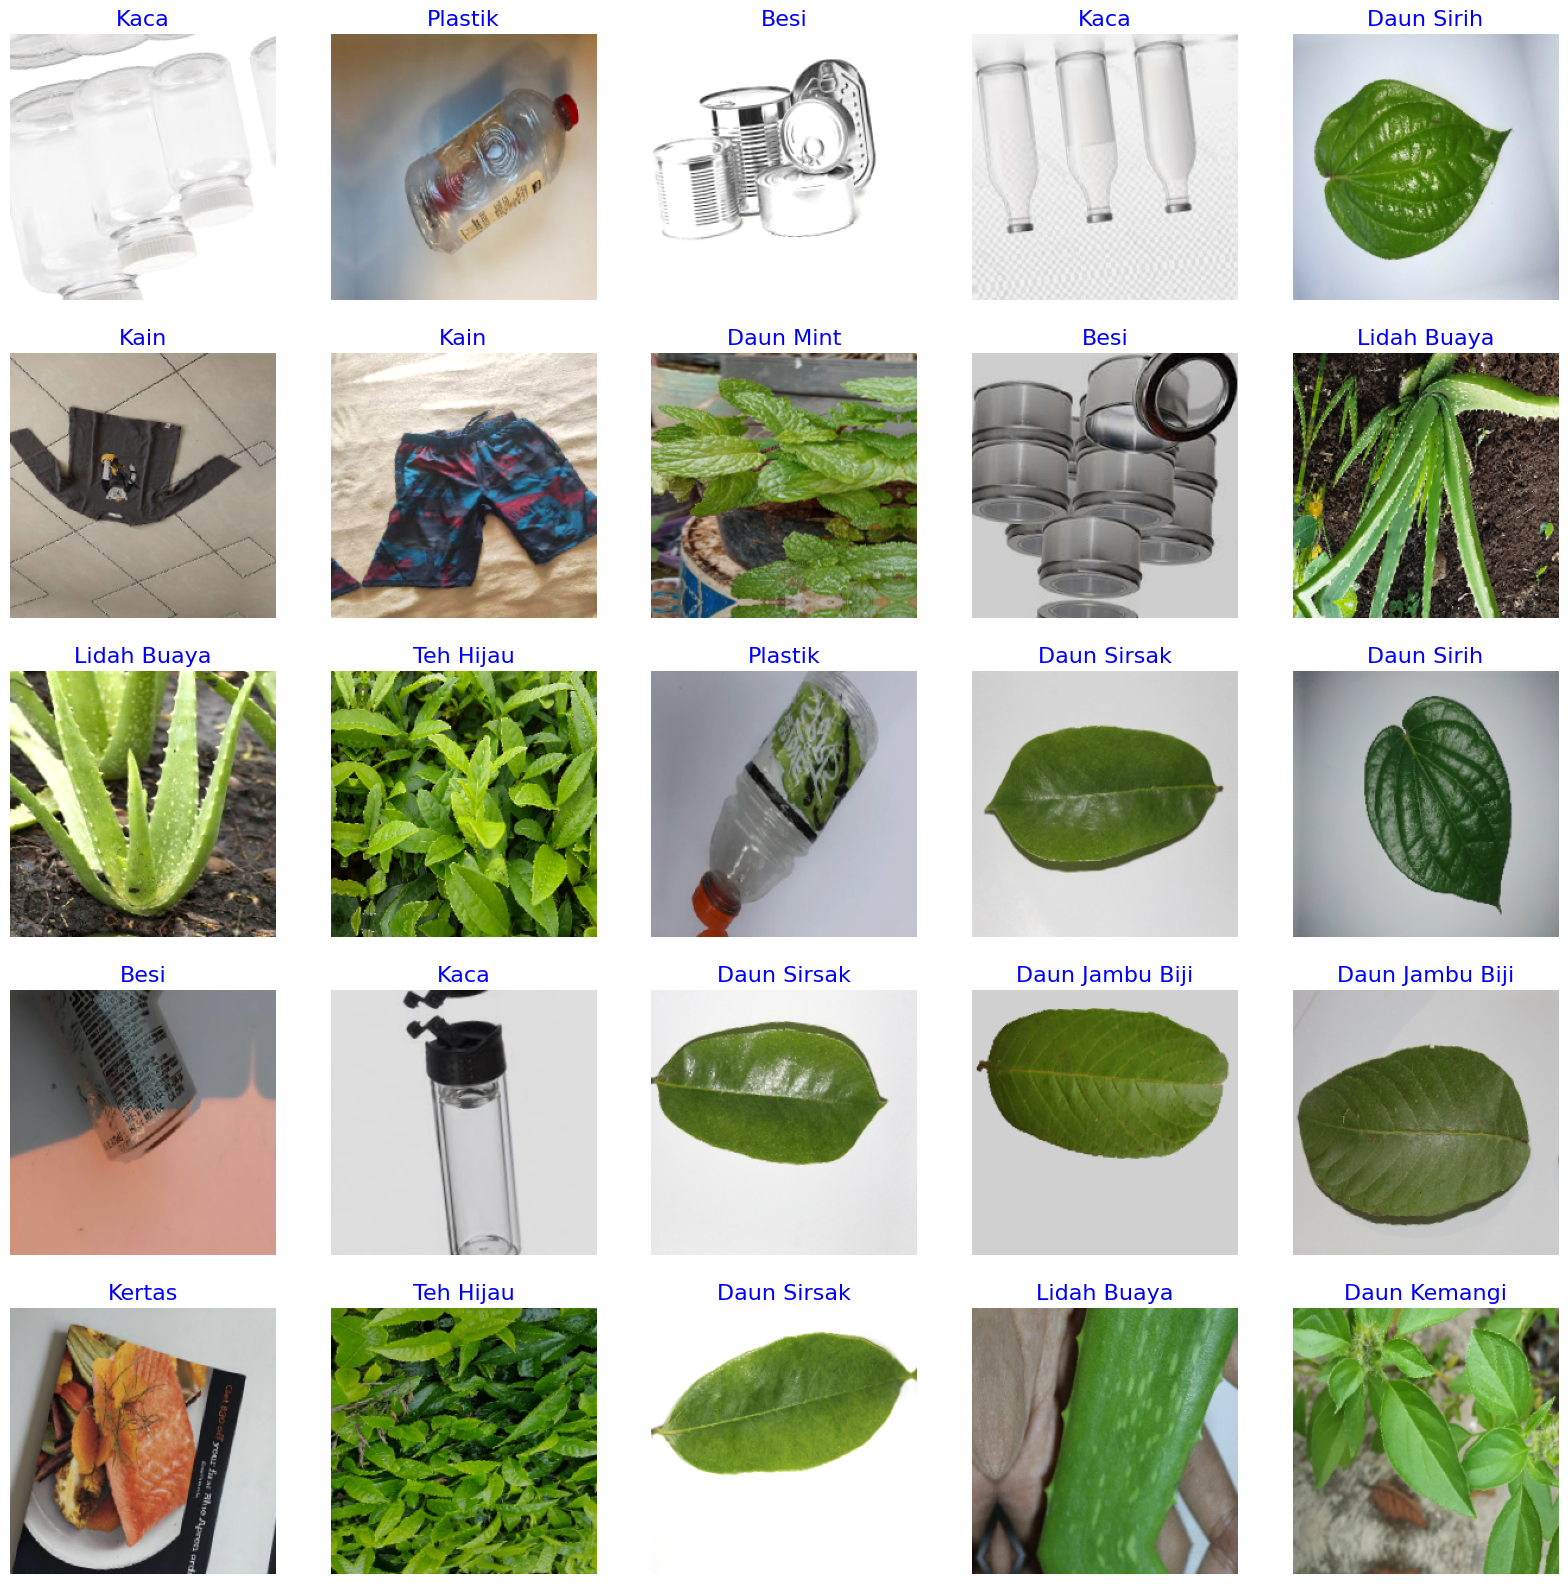

In [ ]:
show_image_samples(train_gen)

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
model_name= 'Anggit'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.Conv2D(filters=32,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.Conv2D(filters=32,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Conv2D(filters=64,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Conv2D(filters=128,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7f852a9ab310>


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          147488    
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          18496     
                                                      

In [ ]:
epochs = 30
history = model.fit(x=train_gen, epochs = epochs, validation_data = valid_gen)

Epoch 1/30
29/29 [==============================] - 355s 12s/step - loss: 2.5375 - accuracy: 0.1237 - val_loss: 1.9515 - val_accuracy: 0.3275
Epoch 2/30
29/29 [==============================] - 314s 11s/step - loss: 1.6257 - accuracy: 0.3508 - val_loss: 1.3249 - val_accuracy: 0.4672
Epoch 3/30
29/29 [==============================] - 306s 11s/step - loss: 1.1761 - accuracy: 0.5211 - val_loss: 0.9355 - val_accuracy: 0.6943
Epoch 4/30
29/29 [==============================] - 303s 11s/step - loss: 0.9157 - accuracy: 0.6284 - val_loss: 0.7830 - val_accuracy: 0.6987
Epoch 5/30
29/29 [==============================] - 300s 10s/step - loss: 0.8545 - accuracy: 0.6727 - val_loss: 0.7265 - val_accuracy: 0.6943
Epoch 6/30
29/29 [==============================] - 302s 10s/step - loss: 0.7650 - accuracy: 0.7148 - val_loss: 0.6498 - val_accuracy: 0.7904
Epoch 7/30
29/29 [==============================] - 299s 10s/step - loss: 0.6513 - accuracy: 0.7510 - val_loss: 0.6696 - val_accuracy: 0.7686
Epoch 

In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    #plot
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.legend()

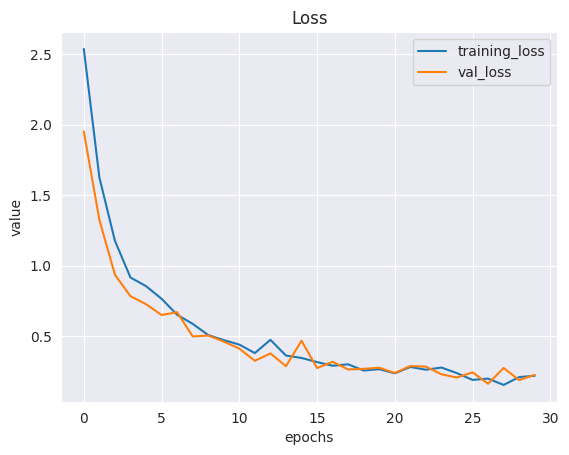

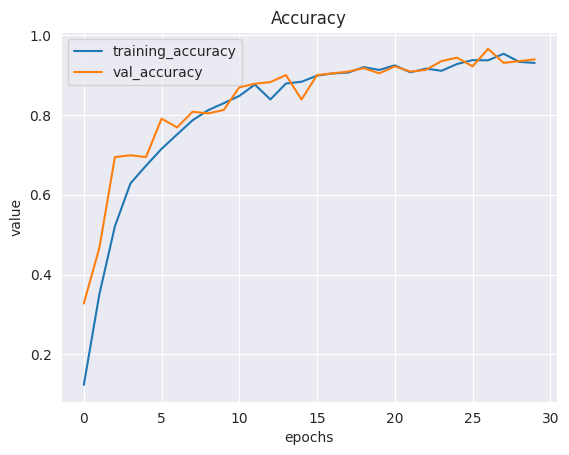

In [ ]:
plot_loss_curves(history)

In [ ]:
model.save('./drive/MyDrive/klasifikasi/modeldatalain16-epoch30.h5')

In [ ]:
model.save('.modeldatalain16-epoch30.h5')

In [ ]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "klasifikasi"
SAVE_MODEL_NAME = "modelAv4-vmodifdata4-7-2-2-datalain16epoch30.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At model/klasifikasi/modelAv4-vmodifdata4-7-2-2-datalain16epoch30.h5...


In [ ]:
model = tf.keras.models.load_model('./drive/MyDrive/klasifikasi/modeldatalain16-epoch30.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open("converted16_30.tflite", "wb").write(tflite_model)

tflite_model.save('')

15130592